In [2]:
import numpy as np
import os.path
import pickle
import pandas as pd
import torch
import matplotlib.pyplot as plt
import requests
import networkx as nx
from geopy import distance
from geopy.distance import lonlat
import random 
from collections import Counter
import dateutil
from dateutil.relativedelta import relativedelta
from requests import HTTPError
from obspy import UTCDateTime
from urllib3.exceptions import ProtocolError
import datetime
import time
from sklearn.metrics import pairwise_distances
from obspy import read as obsread
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook as tqdm


import os
os.environ["PROJ_LIB"] = "C:\\Users\\gabri\\AppData\\Local\\Continuum\\anaconda3\\pkgs\\proj4-5.2.0-ha925a31_1\\Library\\share";
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append("../../../../..")
from definitions import QUAKES_RAW_DATA_PATH
from earthquakes.quakes_util import custom_geo_distance, is_point_in_bbox, get_earthquakes_in_timespan, find_closest_station, UTCDateTime_to_string, \
    string_to_UTCDateTime, quake_filename_to_UTCDateTime, BadDataException, read_pickle, write_pickle, obtain_data, timeit_context, visualize_sensors_graph, create_weighted_adjacency_quakes, \
    visualize_quakes, resample_data
from utils.misc_utils import check_create_folder



In [3]:
NEW_DATASET_FOLDER = os.path.join(QUAKES_RAW_DATA_PATH, "new_dataset_gabriele")

image_folder = os.path.join(NEW_DATASET_FOLDER, "images")

quakes_data_folder = os.path.join(NEW_DATASET_FOLDER, f"w=30", "quakes_data")
quake_filenames = os.listdir(quakes_data_folder)
print(f"{len(quake_filenames)} quakes found.")

stations_in_bbox = pd.read_csv(os.path.join(NEW_DATASET_FOLDER, "stations_in_bbox.csv"))
weighted_adjacency = np.load(os.path.join(NEW_DATASET_FOLDER, "weighted_adjacency.npy"))

print(stations_in_bbox.shape[0], "stations available.")
stations_in_bbox.head()

4838 quakes found.
58 stations available.


Unnamed: 0 #network station   latitude   longitude  elevation  \
0           0       NZ     BFZ -40.679647  176.246245      283.0   
1           1       NZ     BHW -41.408231  174.871115      101.0   
2           2       NZ     BKZ -39.165666  176.492544      706.0   
3           3       NZ    COVZ -39.199914  175.542402     1133.0   
4           4       NZ     CVZ -44.383180  171.006160      454.0   

              sitename            starttime  endtime  
0           Birch Farm  1996-04-03T00:00:00      NaN  
1          Baring Head  1975-11-27T00:00:00      NaN  
2     Black Stump Farm  2004-02-11T00:00:00      NaN  
3  Chateau Observatory  1998-03-25T00:00:00      NaN  
4                 Cave  2014-05-16T00:00:00      NaN

In [4]:
quake_metadata = []
for idx, filename in enumerate(quake_filenames):
    filepath = os.path.join(quakes_data_folder,filename)
    quake_data = read_pickle(filepath)
    
    quake_metadata.append({k:v for k,v in quake_data.items() if k != 'data'})
    
dataset_df = pd.DataFrame([i for i in quake_metadata])
dataset_df['time']= pd.to_datetime(dataset_df['time']) 

labels = list(dataset_df.label.values)
label_counts = Counter(labels)

print(f"There are {len(np.unique(labels))} unique labels in the dataset.")
dataset_df.head(1)

There are 45 unique labels in the dataset.


#eventid                time  latitude  longitude  depth/km author  \
0  2016p594424 2016-08-07 22:29:23   -38.074    177.554      35.8    GNS   

  catalog contributor contributorid magtype  magnitude magauthor  \
0     GNS         GNS   2016p594424       M        3.0       GNS   

       eventlocationname  label  min_distance  wave_length  
0  20 km east of Opotiki     26     29.001221           30

Let's compute the average magnitude at each station (http://ijece.iaescore.com/index.php/IJECE/article/view/8992/11763)


In [5]:
means_by_station = dataset_df.groupby('label').mean()[['depth/km', 'magnitude', 'min_distance']]
std_by_station = dataset_df.groupby('label').std()[['depth/km', 'magnitude', 'min_distance']]

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 16 columns):
#eventid             4838 non-null object
time                 4838 non-null datetime64[ns]
latitude             4838 non-null float64
longitude            4838 non-null float64
depth/km             4838 non-null float64
author               4838 non-null object
catalog              4838 non-null object
contributor          4838 non-null object
contributorid        4838 non-null object
magtype              4838 non-null object
magnitude            4838 non-null float64
magauthor            4838 non-null object
eventlocationname    4838 non-null object
label                4838 non-null int64
min_distance         4838 non-null float64
wave_length          4838 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2), object(8)
memory usage: 604.9+ KB


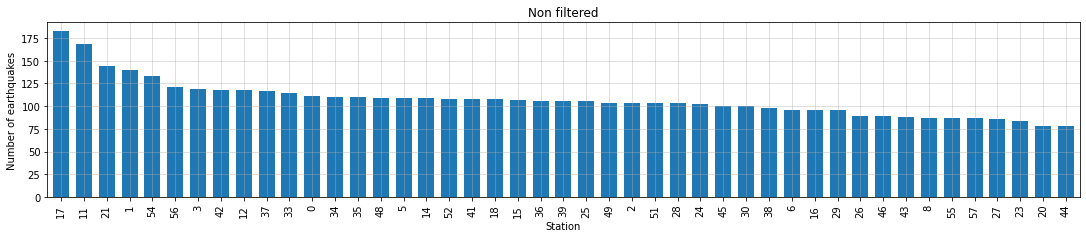

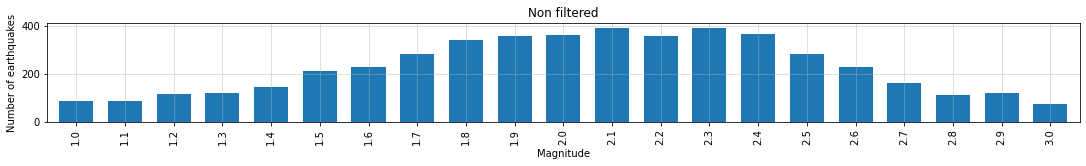

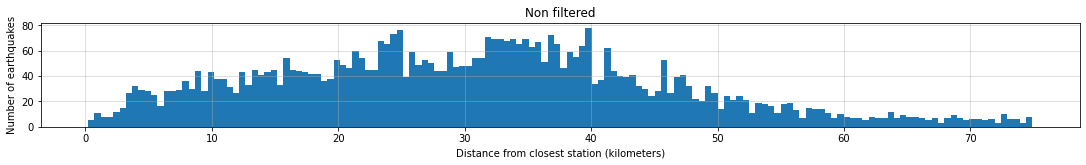

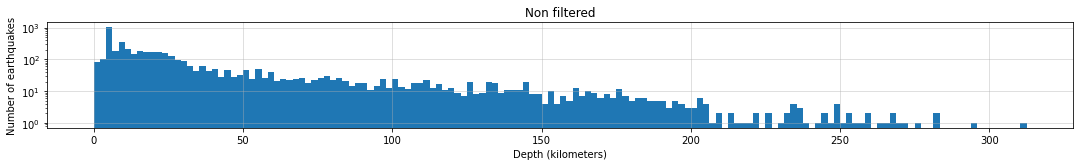

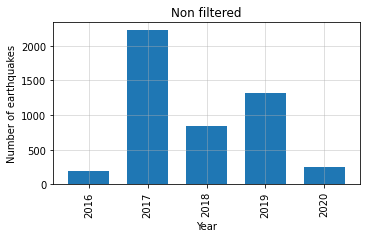

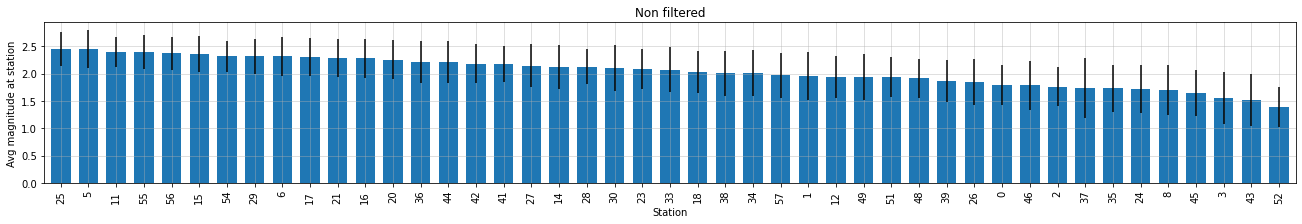

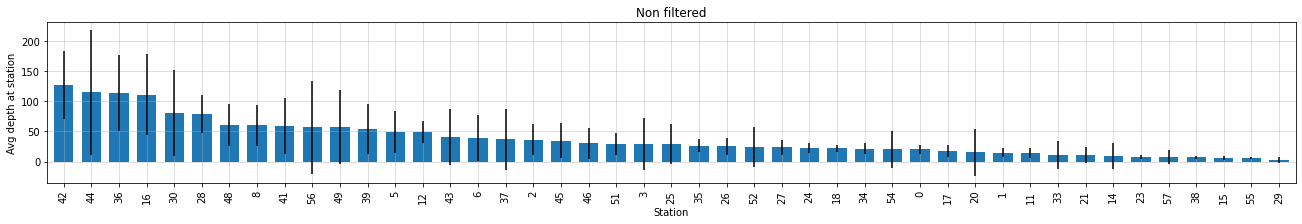

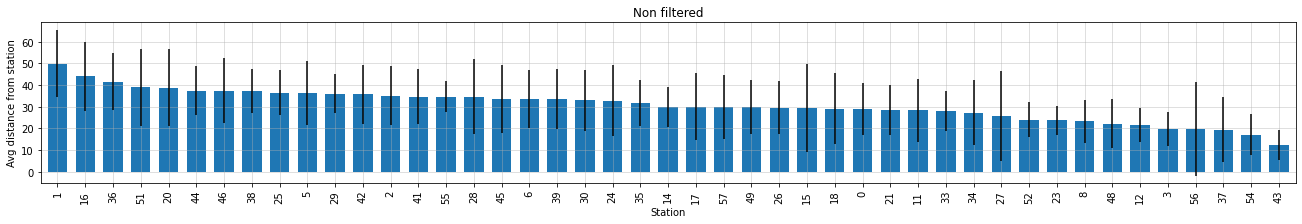

In [5]:
title = 'Non filtered'

plt.figure(figsize=(15, 3))
dataset_df['label'].value_counts().sort_values(ascending=False).plot.bar(width=0.7)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Station")
plt.ylabel("Number of earthquakes")
plt.title(title)
plt.show()


plt.figure(figsize=(15, 2))
dataset_df['magnitude'].value_counts().sort_index().plot.bar(width=0.7)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Magnitude")
plt.ylabel("Number of earthquakes")
plt.title(title)
plt.show()

plt.figure(figsize=(15, 2))
dataset_df.min_distance.sort_values().hist(bins=150)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Distance from closest station (kilometers)")
plt.ylabel("Number of earthquakes")
plt.title(title)
plt.show()

plt.figure(figsize=(15, 2))
dataset_df['depth/km'].sort_values().hist(bins=150)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Depth (kilometers)")
plt.ylabel("Number of earthquakes")
plt.yscale("log")
plt.title(title)
plt.show()


plt.figure(figsize=(5, 3))
dataset_df['time'].dt.year.value_counts().sort_index().plot.bar(width=0.7)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Year")
plt.ylabel("Number of earthquakes")
plt.title(title)
plt.show()



# means and stds

plt.figure(figsize=(18, 3))
means_by_station['magnitude'].sort_values(ascending=False).plot.bar(width=0.7, yerr=std_by_station['magnitude'])
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Station")
plt.ylabel("Avg magnitude at station")
plt.title(title)
plt.show()

plt.figure(figsize=(18, 3))
means_by_station['depth/km'].sort_values(ascending=False).plot.bar(width=0.7, yerr=std_by_station['depth/km'])
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Station")
plt.ylabel("Avg depth at station")
plt.title(title)
plt.show()


plt.figure(figsize=(18, 3))
means_by_station['min_distance'].sort_values(ascending=False).plot.bar(width=0.7, yerr=std_by_station['min_distance'])
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Station")
plt.ylabel("Avg distance from station")
plt.title(title)
plt.show()

## Let's apply a filter on the depth of the earthquakes

In [6]:
maximum_depth = 200

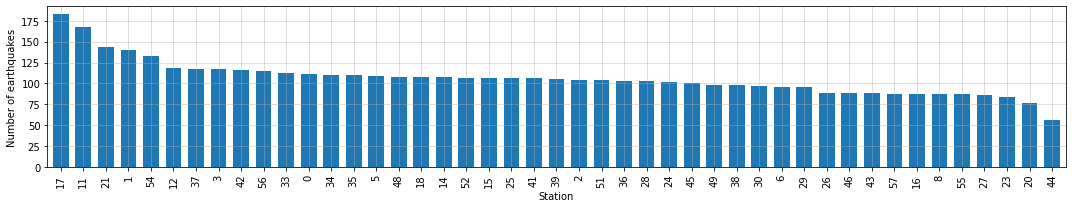

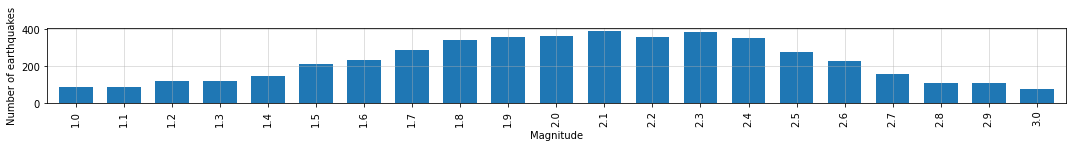

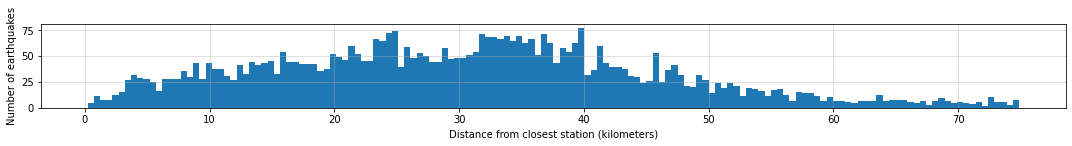

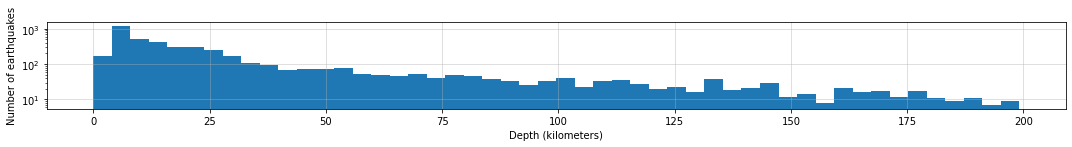

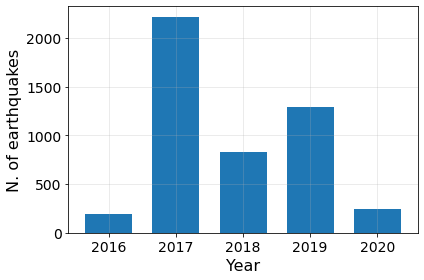

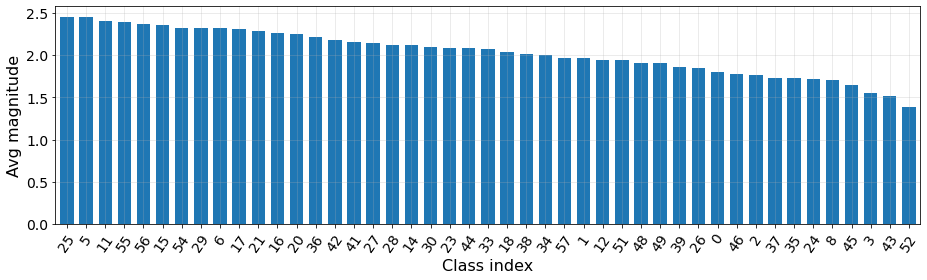

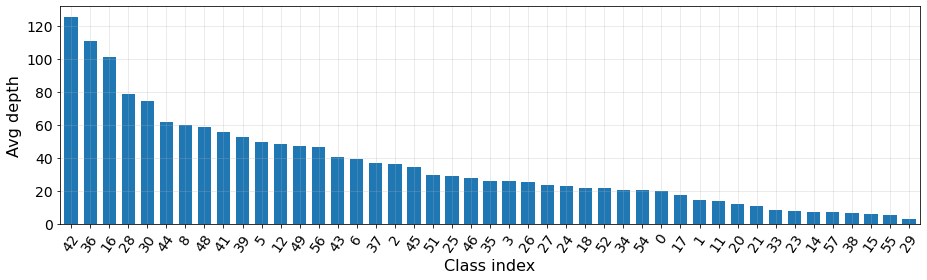

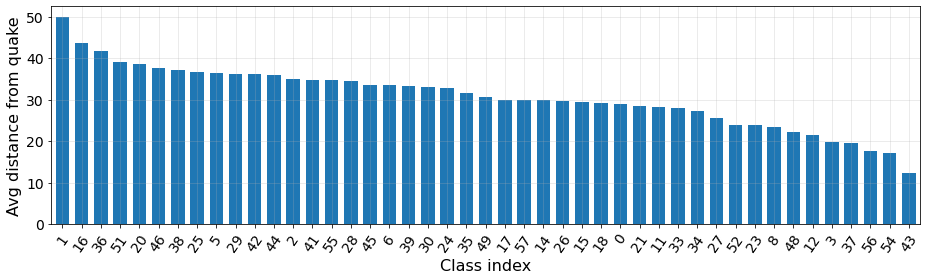

In [9]:
filtered_dataset_df = dataset_df[dataset_df['depth/km'] <= maximum_depth]
filtered_means_by_station = filtered_dataset_df.groupby('label').mean()[['depth/km', 'magnitude', 'min_distance']]
filtered_std_by_station = filtered_dataset_df.groupby('label').std()[['depth/km', 'magnitude', 'min_distance']]


title = f'Filtered data ({filtered_dataset_df.shape[0]} quakes out of {dataset_df.shape[0]})'

plt.figure(figsize=(15, 3))
filtered_dataset_df['label'].value_counts().sort_values(ascending=False).plot.bar(width=0.7)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Station")
plt.ylabel("Number of earthquakes")
# plt.title(title)
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 2))
filtered_dataset_df['magnitude'].value_counts().sort_index().plot.bar(width=0.7)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Magnitude")
plt.ylabel("Number of earthquakes")
# plt.title(title)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 2))
filtered_dataset_df.min_distance.sort_values().hist(bins=150)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.xlabel("Distance from closest station (kilometers)")
plt.ylabel("Number of earthquakes")
# plt.title(title)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 2))
filtered_dataset_df['depth/km'].sort_values().hist(bins=50)
plt.grid(alpha=0.5)
plt.xlabel("Depth (kilometers)")
plt.ylabel("Number of earthquakes")
# plt.title(title)
plt.yscale("log")
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
filtered_dataset_df['time'].dt.year.value_counts().sort_index().plot.bar(width=0.7)
plt.grid(alpha=0.3)
plt.xlabel("Year", fontsize=16)
plt.ylabel("N. of earthquakes", fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14)
# plt.title(title)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "n_of_quakes_per_year.pdf"))
plt.show()



# means and stds
#TODO: if we want to show the errorbars we need to perform the sorting together
plt.figure(figsize=(13, 4))
errors = np.array(filtered_std_by_station['magnitude'].sort_values(ascending=False).values)
filtered_means_by_station['magnitude'].sort_values(ascending=False).plot.bar(width=0.7)# , yerr=errors)
plt.grid(alpha=0.3)
plt.xlabel("Class index", fontsize=16)
plt.ylabel("Avg magnitude", fontsize=16)
plt.xticks(fontsize=14, rotation=55)
plt.yticks(fontsize=14)
# plt.title(title)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "avg_magnitude_per_class.pdf"))
plt.show()




plt.figure(figsize=(13, 4))
filtered_means_by_station['depth/km'].sort_values(ascending=False).plot.bar(width=0.7) # , yerr=filtered_std_by_station['depth/km'])
plt.grid(alpha=0.3)
plt.xlabel("Class index", fontsize=16)
plt.ylabel("Avg depth", fontsize=16)
plt.xticks(fontsize=14, rotation=55)
plt.yticks(fontsize=14)
# plt.title(title)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "avg_depth_per_class.pdf"))
plt.show()


plt.figure(figsize=(13, 4))
filtered_means_by_station['min_distance'].sort_values(ascending=False).plot.bar(width=0.7) #, yerr=filtered_std_by_station['min_distance'])

plt.grid(alpha=0.3)
plt.xlabel("Class index", fontsize=16)
plt.ylabel("Avg distance from quake", fontsize=16)
plt.xticks(fontsize=14, rotation=55)
plt.yticks(fontsize=14)
# plt.title(title)
plt.tight_layout()
plt.savefig(os.path.join(image_folder, "avg_dist_per_class.pdf"))
plt.show()

## Map Visualization

In [10]:
# taken from https://www.openstreetmap.org/export
bounding_box = [
    166.104, # left lower corner longitude
    178.990, # upper right corner longitude
    -47.749, # left lower corner latitude
    -33.779, # upper right corner latitude
]

nz_basemap = Basemap(
        projection='merc',
        llcrnrlon=bounding_box[0],  # left lower corner longitude
        llcrnrlat=bounding_box[2],  # left lower corner latitude
        urcrnrlon=bounding_box[1],
        urcrnrlat=bounding_box[3],
        lat_ts=0,
        resolution='c',
        suppress_ticks=True)

C:\Users\gabri\AppData\Local\Continuum\anaconda3\envs\tud_ml4se\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


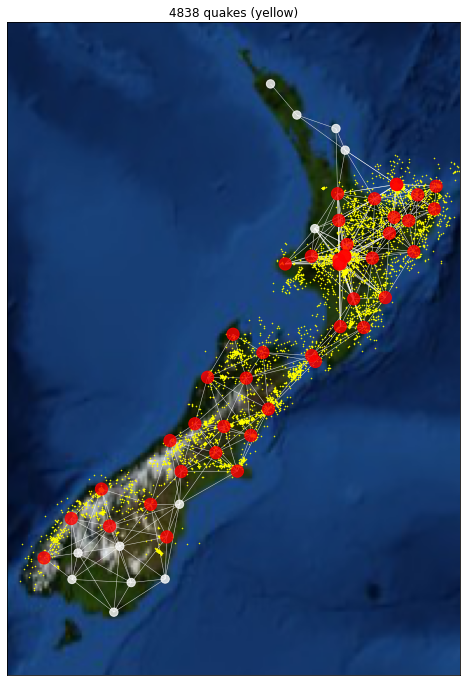

In [11]:
plt.figure(figsize=(12, 12))

quakes_latitudes=list(dataset_df['latitude'].astype(float).values)
quakes_longitudes=list(dataset_df['longitude'].astype(float).values)
visualize_quakes(quakes_longitudes, quakes_latitudes, nz_basemap, nodesize=0.3, nodecolor="yellow", alpha=1, title="")

station_lats = list(stations_in_bbox.latitude.values)
station_lons=list(stations_in_bbox.longitude.values)
   
unique_labels = list(np.unique(dataset_df.label.values))
station_colors = []
station_sizes = []
for station_idx in range(len(station_lats)):
    if station_idx in unique_labels:
        station_colors.append('red')
        station_sizes.append(150)
    else:
        station_colors.append('white')
        station_sizes.append(70)
    
visualize_sensors_graph(station_lons, station_lats, weighted_adjacency, 
                        nz_basemap, nodesize=station_sizes, nodecolor=station_colors, 
                        draw_edges=True, edgecolors='white', with_labels=False,
                       alpha=0.8)

title = f"{dataset_df.shape[0]} quakes (yellow)"
plt.title(title)
nz_basemap.bluemarble()
plt.show()

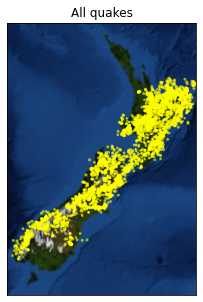

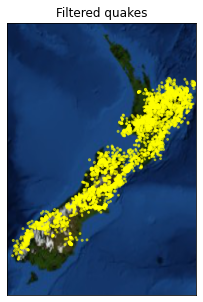

In [12]:
plt.figure(figsize=(5, 5))

quakes_latitudes= list(dataset_df['latitude'].astype(float).values)
quakes_longitudes= list(dataset_df['longitude'].astype(float).values)
quakes_magnitudes = list(dataset_df['magnitude'].astype(float).values)

m = interp1d([np.min(quakes_magnitudes),np.max(quakes_magnitudes)],[1,5])
quake_sizes = [m(i) for i in quakes_magnitudes]

visualize_quakes(quakes_longitudes, quakes_latitudes, nz_basemap, nodesize=quake_sizes, nodecolor="yellow", alpha=0.5, title="")

nz_basemap.bluemarble()
plt.title("All quakes")
plt.show()

plt.figure(figsize=(5, 5))

quakes_latitudes= list(filtered_dataset_df['latitude'].astype(float).values)
quakes_longitudes= list(filtered_dataset_df['longitude'].astype(float).values)
quakes_magnitudes = list(filtered_dataset_df['magnitude'].astype(float).values)

m = interp1d([np.min(quakes_magnitudes),np.max(quakes_magnitudes)],[1,5])
quake_sizes = [m(i) for i in quakes_magnitudes]

visualize_quakes(quakes_longitudes, quakes_latitudes, nz_basemap, nodesize=quake_sizes, nodecolor="yellow", alpha=0.5, title="")

nz_basemap.bluemarble()
plt.title("Filtered quakes")
plt.show()

In [13]:
filtered_dataset_df.head()

#eventid                time  latitude  longitude  depth/km author  \
0  2016p594424 2016-08-07 22:29:23   -38.074    177.554      35.8    GNS   
1  2016p594555 2016-08-07 23:39:32   -38.433    176.210       3.8    GNS   
2  2016p595592 2016-08-08 08:51:56   -44.469    169.541       5.0    GNS   
3  2016p596786 2016-08-08 19:28:00   -42.153    172.790      32.3    GNS   
4  2016p597309 2016-08-09 00:06:15   -37.947    178.356       9.7    GNS   

  catalog contributor contributorid magtype  magnitude magauthor  \
0     GNS         GNS   2016p594424       M        3.0       GNS   
1     GNS         GNS   2016p594555       M        1.5       GNS   
2     GNS         GNS   2016p595592       M        2.4       GNS   
3     GNS         GNS   2016p596786       M        2.5       GNS   
4     GNS         GNS   2016p597309       M        2.3       GNS   

             eventlocationname  label  min_distance  wave_length  
0        20 km east of Opotiki     26     29.001221           30  
1         30 km north of Taupo     42     59.697115           30  
2   40 km north-east of Wanaka     20     51.926271           30  
3     35 km south of St Arnaud     41     44.454260           30  
4  5 km south-east of Ruatoria     34     16.327205           30

Min: 56 | Max: 183


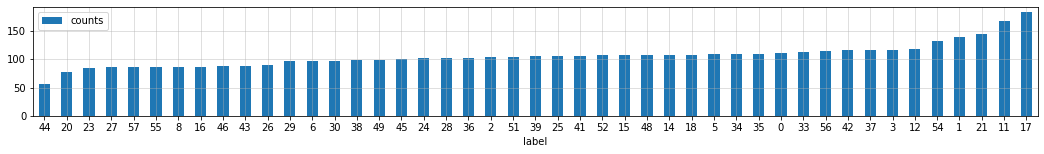

In [14]:
count_df = filtered_dataset_df.groupby('label').size()
count_df = count_df.reset_index(name='counts')
count_df['label'] = count_df['label'].astype(int)

min_available_training_per_class = count_df.counts.min()
max_available_training_per_class = count_df.counts.max()
print(f"Min: {min_available_training_per_class} | Max: {max_available_training_per_class}")

count_df.sort_values('counts').plot.bar(x='label', y='counts', rot=0, figsize=(18, 2))
plt.grid(alpha=0.5)
plt.show()

In [15]:
clipping_value = 125

Obtained 4633 final quakes.


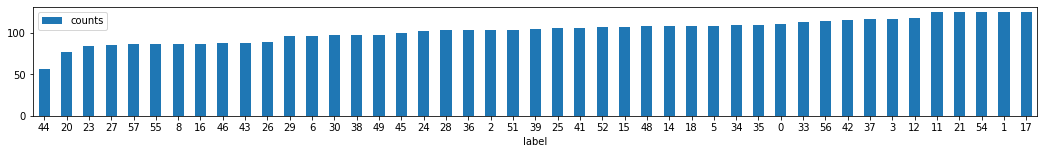

In [16]:
grouped = filtered_dataset_df.groupby('label')

final_quakes_idxs_balanced = []
for label, group in grouped:
    quake_idxs_in_group = list(group['#eventid'].values)
    if len(quake_idxs_in_group) >= clipping_value:        
        selected_idxs = random.sample(quake_idxs_in_group, clipping_value)
    else:
        selected_idxs = quake_idxs_in_group
        
    final_quakes_idxs_balanced += selected_idxs

print(f"Obtained {len(final_quakes_idxs_balanced)} final quakes.")
final_quakes_df_balanced = filtered_dataset_df[filtered_dataset_df['#eventid'].isin(final_quakes_idxs_balanced)]

final_quakes_df_balanced.groupby('label').size().reset_index(name='counts').sort_values('counts').plot.bar(x='label', y='counts', rot=0, figsize=(18, 2))
plt.show()

Now, given the earthquake IDs that we have in the final dataframe, we reach out to the .pickle file of each earthquake and then get the 'data' field, which contains the seismic waves.

In [17]:
filenames_for_dataset = [os.path.join(quakes_data_folder,f"quake_{quake_idx}.pickle") for quake_idx in final_quakes_idxs_balanced]
print(filenames_for_dataset[0])
print(len(filenames_for_dataset))

C:\Users\gabri\Desktop\new_thesis_project\earthquakes\data\new_dataset_gabriele\w=30\quakes_data\quake_2016p616405.pickle
4633


In [18]:
DESIRED_HERTZ = 2

data_100hz = read_pickle(filenames_for_dataset[0])['data']
print(f"Initial shape: {data_100hz.shape}")
step = int(100/DESIRED_HERTZ)
n_timesteps = int(data_100hz.shape[1]/step)
print(f"Step for donwsampling: {step}")
data_out = resample_data(np.expand_dims(data_100hz, axis=0), n_timesteps)[0]
print(f"Final shape: {data_out.shape}")

Initial shape: (58, 6000)
Step for donwsampling: 50
Final shape: (58, 120)


In [19]:
n_samples = len(final_quakes_idxs_balanced)
n_stations = 58
n_timesteps = DESIRED_HERTZ * 60  # we crawl 60 seconds of waves

packaged_downsampled_dataset = np.zeros([n_samples, n_stations, n_timesteps])
packaged_labels = np.zeros([n_samples])

for quake_idx, filename in enumerate(tqdm(filenames_for_dataset)):
    quake_dict = read_pickle(filename)
    data_100hz = quake_dict['data']
    quake_label = quake_dict['label']
#     packaged_downsampled_quake_dict['data']dataset[quake_idx] = data_100hz[:, ::step]
    packaged_downsampled_dataset[quake_idx] = resample_data(np.expand_dims(data_100hz, axis=0), n_timesteps)[0]
    packaged_labels[quake_idx] = quake_label

In [20]:
print(packaged_downsampled_dataset.shape, packaged_labels.shape)

(4633, 58, 120) (4633,)


## We need to remap the labels

In [19]:
unique_labels = np.unique(packaged_labels)
print(unique_labels)
num_unique_labels = len(unique_labels)
print(f"{num_unique_labels} unique labels in dataset.")

label2class_dict = {int(label):int(target) for target, label in enumerate(unique_labels)}
class2label_dict = {value:key for key, value in label2class_dict.items()}

for idx, label in enumerate(packaged_labels):
    packaged_labels[idx] = label2class_dict[label]
print(np.unique(packaged_labels))  

[  0.   1.   2.   3.   5.   6.   8.  11.  12.  14.  15.  16.  17.  18.  20.
  21.  23.  24.  25.  26.  27.  28.  29.  30.  33.  34.  35.  36.  37.  38.
  39.  41.  42.  43.  44.  45.  46.  48.  49.  51.  52.  54.  55.  56.  57.]
45 unique labels in dataset.
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.]


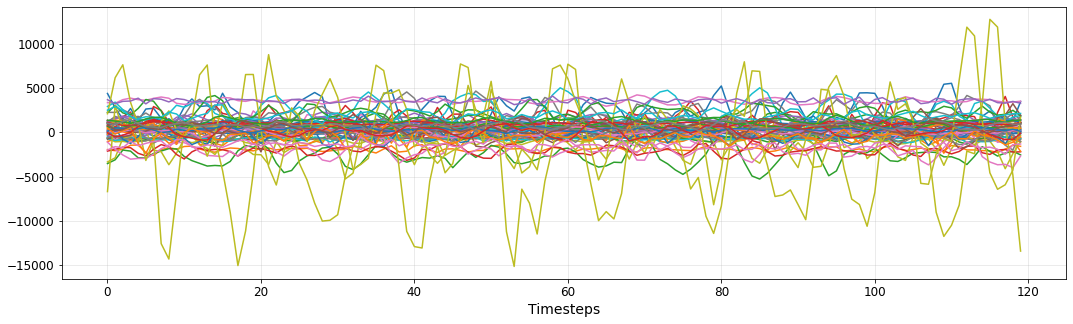

In [55]:
plt.figure(figsize=(18, 5))
plt.plot(packaged_downsampled_dataset[4600, :, :].transpose())

plt.xlabel("Timesteps", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

plt.savefig(os.path.join(image_folder, f"waveforms.png"))


plt.show()

In [21]:
dataset_path = os.path.join(NEW_DATASET_FOLDER, "packaged")
check_create_folder(dataset_path)

data_name = f"data_downsampledAt{DESIRED_HERTZ}Hz.npy"
labels_name = "labels.npy"

data_path = os.path.join(dataset_path, data_name)
labels_path = os.path.join(dataset_path, labels_name)
print(data_path)
print(labels_path)

C:\Users\gabri\Desktop\new_thesis_project\earthquakes\data\new_dataset_gabriele\packaged\data_downsampledAt2Hz.npy
C:\Users\gabri\Desktop\new_thesis_project\earthquakes\data\new_dataset_gabriele\packaged\labels.npy


# Save the dataset

In [25]:
# np.save(data_path, packaged_downsampled_dataset)
# np.save(labels_path, packaged_labels)

# write_pickle(label2class_dict, os.path.join(dataset_path, "label2class_dict.pickle"))
# write_pickle(class2label_dict, os.path.join(dataset_path, "class2label_dict.pickle"))

# Visualization of raw and normalized data

In [26]:
packaged_downsampled_dataset.shape

(4633, 58, 120)

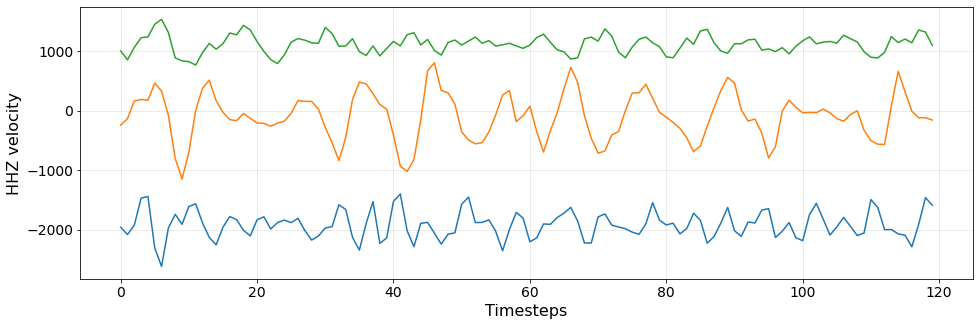

In [41]:
# raw
earthquake_index = 4600
sensor_indices = np.array([1, 20, 30])



plt.figure(figsize=(16, 5))
plt.plot(packaged_downsampled_dataset[earthquake_index, sensor_indices, :].transpose())

plt.xlabel("Timesteps", fontsize=16)
plt.ylabel("HHZ velocity", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)

plt.savefig(os.path.join(image_folder, f"waveforms.pdf"))


plt.show()

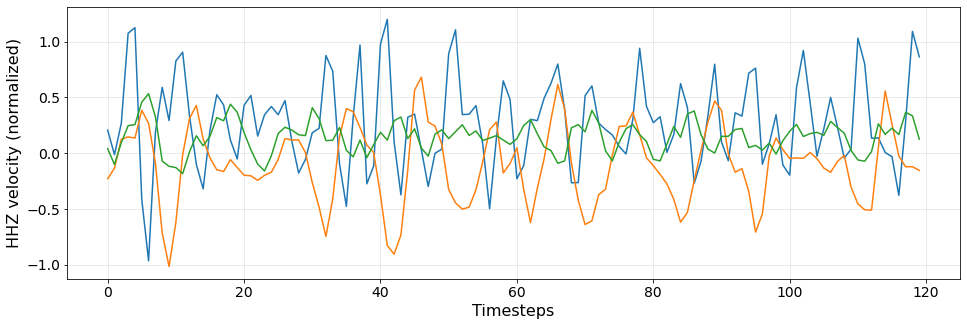

In [40]:
# normalized
N_stations = 58

normalized_data = np.zeros(packaged_downsampled_dataset.shape)
for station_idx in range(N_stations):
    station_metadata = {}
    station_data_for_normalization = packaged_downsampled_dataset[:, station_idx, :]
    station_metadata['mean'] = np.mean(station_data_for_normalization)
    station_metadata['std'] = np.std(station_data_for_normalization)

    # normalize ALL data using the values computed with the normalization data
    normalized_data[:, station_idx, :] = (packaged_downsampled_dataset[:, station_idx, :] - station_metadata['mean']) / station_metadata['std']

plt.figure(figsize=(16, 5))
plt.plot(normalized_data[earthquake_index, sensor_indices, :].transpose())

plt.xlabel("Timesteps", fontsize=16)
plt.ylabel("HHZ velocity (normalized)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(alpha=0.3)

plt.savefig(os.path.join(image_folder, f"waveforms_norm.pdf"))


plt.show()